=== OpenCV Image Recognition System ===
This program demonstrates basic image processing and object detection


How would you like to provide the image?
1. Upload an image
2. Use sample image
3. Take a photo (webcam)
Enter your choice (1-3): 1

Please upload an image file...


No file uploaded. Using sample image instead.

Using sample image...


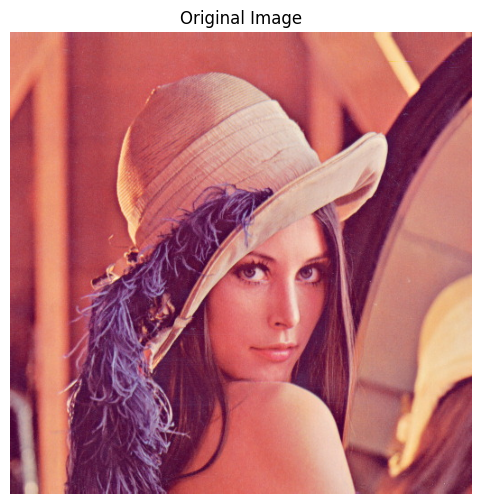


What would you like to detect?
1. Faces
2. Color-based objects
3. All basic processing
Enter your choice (1-3): 3


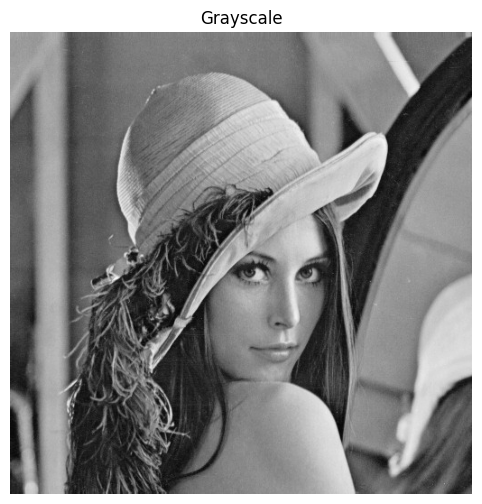

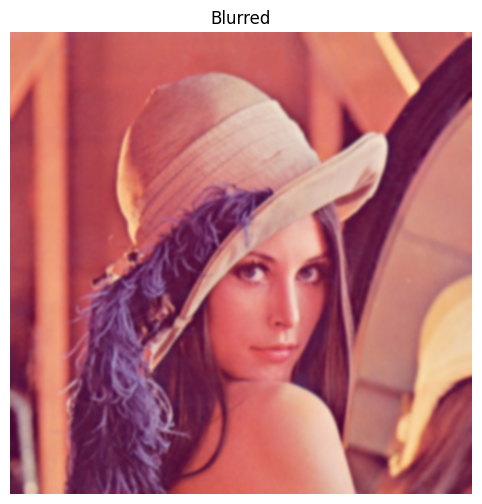

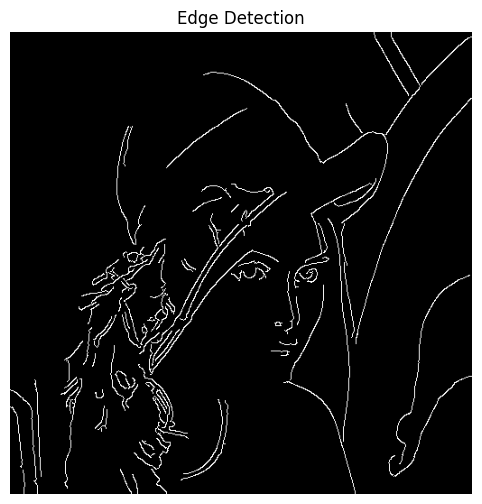

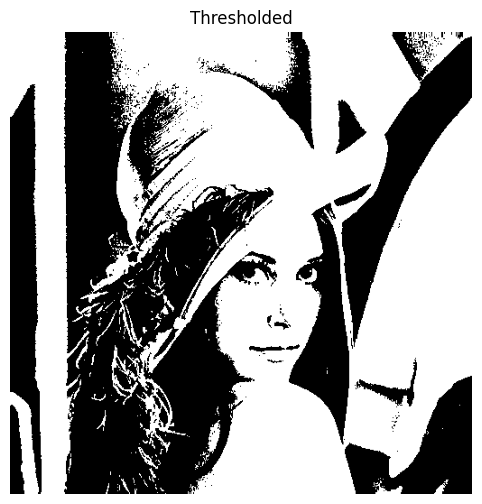


Would you like to process another image? (y/n): y

How would you like to provide the image?
1. Upload an image
2. Use sample image
3. Take a photo (webcam)
Enter your choice (1-3): 3

Preparing webcam... Look at the camera and click 'Capture'


<IPython.core.display.Javascript object>

Webcam error: NotAllowedError: Permission denied. Using sample image instead.

Using sample image...


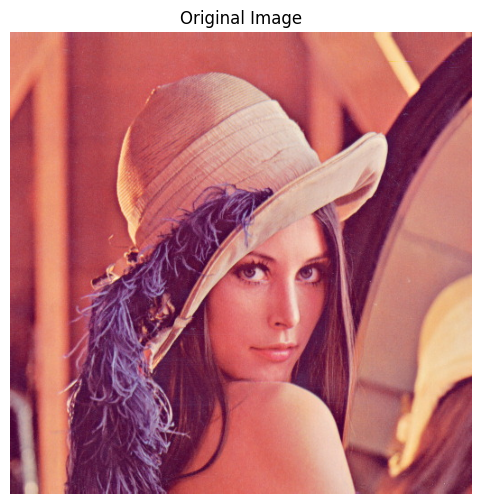


What would you like to detect?
1. Faces
2. Color-based objects
3. All basic processing


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import urllib.request
import os
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js

def upload_image():
    """Allow user to upload an image file"""
    uploaded = files.upload()
    for filename in uploaded.keys():
        return filename
    return None

def take_photo():
    """Capture image from webcam (works in Colab)"""
    js = Javascript('''
    async function takePhoto() {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', 0.92);
    }
    ''')
    display(js)
    data = eval_js('takePhoto()')
    binary = urllib.request.urlopen(data).read()
    with open('photo.jpg', 'wb') as f:
        f.write(binary)
    return 'photo.jpg'

def get_user_image():
    """Get image based on user choice"""
    print("\nHow would you like to provide the image?")
    print("1. Upload an image")
    print("2. Use sample image")
    print("3. Take a photo (webcam)")

    choice = input("Enter your choice (1-3): ")

    if choice == '1':
        print("\nPlease upload an image file...")
        filename = upload_image()
        if filename:
            return filename
        else:
            print("No file uploaded. Using sample image instead.")
    elif choice == '3':
        try:
            print("\nPreparing webcam... Look at the camera and click 'Capture'")
            return take_photo()
        except Exception as e:
            print(f"Webcam error: {e}. Using sample image instead.")

    # Default to sample image
    print("\nUsing sample image...")
    if not os.path.exists('lena.jpg'):
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg",
            "lena.jpg")
    return 'lena.jpg'

def process_image(image_path):
    """Main processing function"""
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image")
        return

    # Display original
    display_image(img, "Original Image")

    # Ask what processing to perform
    print("\nWhat would you like to detect?")
    print("1. Faces")
    print("2. Color-based objects")
    print("3. All basic processing")

    choice = input("Enter your choice (1-3): ")

    if choice == '1':
        detect_faces(img)
    elif choice == '2':
        detect_colored_objects(img)
    else:
        basic_processing(img)

def detect_faces(img):
    """Detect faces in image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    result = img.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(result, (x, y), (x+w, y+h), (255, 0, 0), 2)

    display_image(result, f"Detected {len(faces)} Faces")

def detect_colored_objects(img):
    """Detect objects by color"""
    print("\nWhat color would you like to detect?")
    print("1. Red")
    print("2. Blue")
    print("3. Green")
    print("4. Custom color")

    choice = input("Enter your choice (1-4): ")

    if choice == '1':
        target_color = (0, 0, 255)  # Red in BGR
    elif choice == '2':
        target_color = (255, 0, 0)  # Blue in BGR
    elif choice == '3':
        target_color = (0, 255, 0)  # Green in BGR
    else:
        r = int(input("Enter Red value (0-255): "))
        g = int(input("Enter Green value (0-255): "))
        b = int(input("Enter Blue value (0-255): "))
        target_color = (b, g, r)  # Convert to BGR

    # Convert to HSV
    target_color_hsv = cv2.cvtColor(np.uint8([[target_color]]), cv2.COLOR_BGR2HSV)[0][0]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Create mask
    lower = np.array([target_color_hsv[0]-10, 100, 100])
    upper = np.array([target_color_hsv[0]+10, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw results
    result = img.copy()
    for cnt in contours:
        if cv2.contourArea(cnt) > 100:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)

    display_image(mask, "Color Mask")
    display_image(result, "Detected Objects")

def basic_processing(img):
    """Show basic image processing steps"""
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    display_image(gray, "Grayscale")

    # Blurred
    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    display_image(blurred, "Blurred")

    # Edges
    edges = cv2.Canny(blurred, 100, 200)
    display_image(edges, "Edge Detection")

    # Threshold
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
    display_image(thresh, "Thresholded")

def display_image(image, title="Image"):
    """Display image with matplotlib"""
    plt.figure(figsize=(8, 6))
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def main():
    print("=== OpenCV Image Recognition System ===")
    print("This program demonstrates basic image processing and object detection\n")

    while True:
        image_path = get_user_image()
        process_image(image_path)

        again = input("\nWould you like to process another image? (y/n): ").lower()
        if again != 'y':
            print("\nThank you for using the image recognition system!")
            break

if __name__ == "__main__":
    main()